In [22]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os
from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime, timedelta

from support.pd_support import *
from support.ar_calculations import *


from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick

from scipy.signal import savgol_filter

In [23]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "validation"
_calib_folder_name = "calibration_00"

# _folder_name = "ar_30_5_quad_random_slow_01"
_folder_name = "skimu2_30_4_random_45min_1"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_validation_imu_3.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


Marker IDS

In [24]:
_om = get_rb_marker_name(4)
_xm = get_rb_marker_name(1)
_zm = get_rb_marker_name(3)

In [25]:
timeoffset = 0.0
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.011
filter_size = 51
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])

_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time"))

#change string to float
_imu_df = _imu_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))

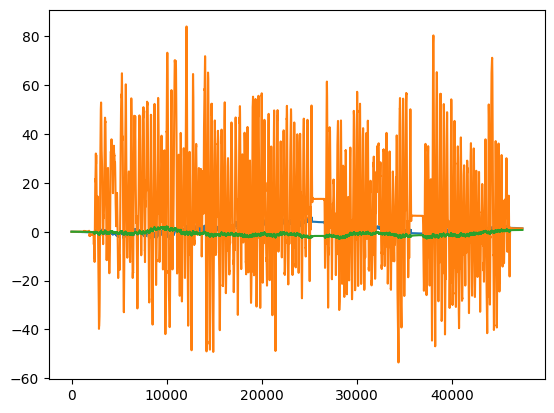

In [26]:
plt.plot(_imu_df['ang_x'])
plt.plot(_imu_df['ang_z'])
plt.plot(_imu_df['ang_y'])

In [27]:
_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_imu_pth)), 'validation', f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [28]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [29]:
# @njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [30]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})


In [31]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

In [32]:
for idx, val in enumerate(_imu_df["sync"]):
    if val == 1:
        break
_imu_df = _imu_df[idx:]
_time_offset = _imu_df['time'][0] - _m_df['time'][0]

In [33]:
_imu_df = _imu_df.with_columns([(pl.col('time') - _time_offset).alias('time')])

In [34]:
_imu_df, _m_df = trunkate_dfs(_imu_df.to_pandas(), _m_df.to_pandas())
_imu_df = pl.from_pandas(_imu_df)
_m_df = pl.from_pandas(_m_df)

In [35]:
_x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]].to_numpy()
_org = _m_df[[_om["x"], _om["y"], _om["z"]]].to_numpy()
_z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]].to_numpy()

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    _rotmat_i.append(calculate_rotmat(_x_vec[i].reshape((3, 1)), _z_vec[i].reshape((3, 1)), _org[i].reshape((3, 1))))
    
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 62929/62929 [00:00<00:00, 314450.00it/s]


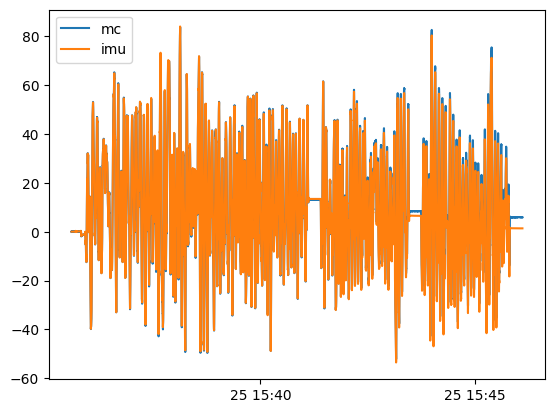

In [36]:
inx = np.random.randint(len(_imu_df))

plt.plot(_m_df['time'],_theta_y, label = 'mc')
plt.plot(_imu_df['time'], _imu_df['ang_z'], label='imu')
# plt.xlim(_imu_df['time'][inx], _imu_df["time"][inx]+ timedelta(seconds=60))
plt.legend()


In [37]:
f = interp1d(_m_df['time'].dt.epoch(), _theta_y, kind='linear')  # You can also use 'cubic' or other interpolation methods
_theta_y_1 = f(_imu_df['time'].dt.epoch())

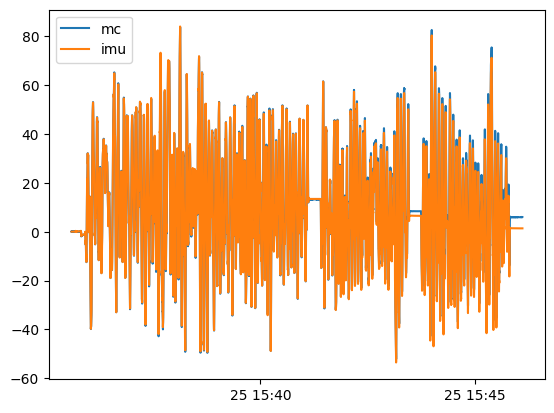

In [38]:
inx = np.random.randint(len(_imu_df))

plt.plot(_imu_df['time'],_theta_y_1, label = 'mc')
plt.plot(_imu_df['time'], _imu_df['ang_z'], label='imu')
plt.legend()

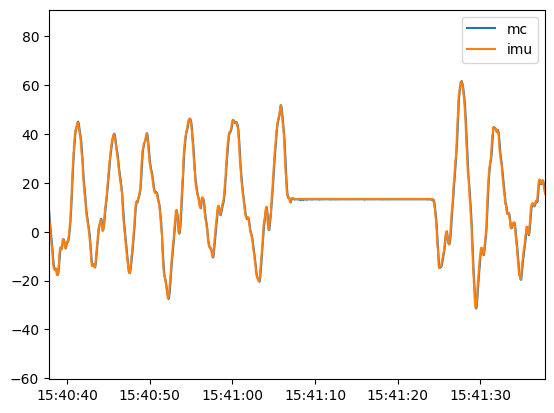

In [39]:
inx = np.random.randint(len(_imu_df))

plt.plot(_m_df['time'],_theta_y, label = 'mc')
plt.plot(_imu_df['time'], _imu_df['ang_z'], label='imu')
plt.xlim(_imu_df['time'][inx], _imu_df["time"][inx]+ timedelta(seconds=60))
plt.legend()

In [40]:
_time = _imu_df['time'].dt.minute() + _imu_df['time'].dt.second()/60 + _imu_df['time'].dt.millisecond()/(1000*60)
_time = _time - _time[0]

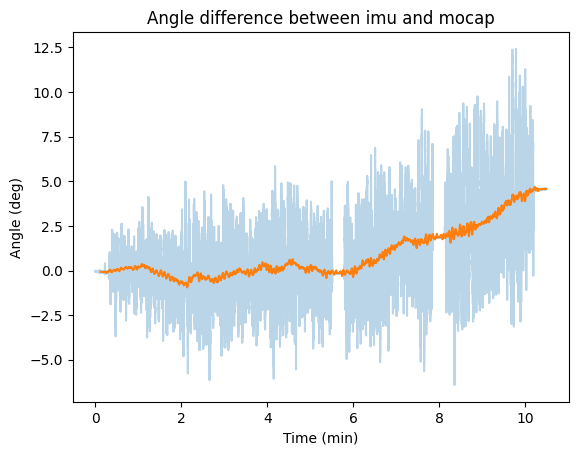

In [41]:
filtered = savgol_filter((_theta_y_1 - _imu_df['ang_z']), 1001, 1)
plt.plot(_time,(_theta_y_1 - _imu_df['ang_z']), alpha=0.3)
plt.xlabel('Time (min)')
plt.ylabel('Angle (deg)')
plt.title('Angle difference between imu and mocap')
plt.plot(_time,filtered)

In [57]:

import plotly.io as pio
import plotly.express as px

pio.renderers.default = "vscode"
# fig = px.line(x=["a", "b", "c"], y=[1, 3, 2])
# _time,(_theta_y_1 - _imu_df['ang_z']), alpha=0.3
fig = px.line(x=_time, y=(_theta_y_1 - _imu_df['ang_z']))
# fig.add_line(x=_time, y=filtered)
fig.show()